# Time Series Forecasting

Time series is a sequence of observations recorded at **regular intervals**. 

In a time series forecasting, time is often the independent variable and the goal is usually to make a forecast for the future.

#### How TS forecasting is different than regular regression problem?
1. data is time dependent or value at current time depends on previous values
2. along with trend, time series also exhibit some seasonality.

We will look at following topics:
1. Time series analysis
2. Traditional models to forecast TS and their limitations
3. FbProphet
4. Ensemble of FbProphet with other ML models

For this topic we will use data of daily transactions of a retail store. Data is available from 2010 to 2015.

# Time Series Analysis

Time-series analysis is a very crucial step for selecting the model. A model is selected based on the characteristics of the time series. There is no single model which works best of all time-series.

### Characteristics of time-series:
1. Trend: increasing or decreasing slope
2. Seasonality: periodic fluctuations
3. Stationarity:
    - A time series is said to be stationary if its statistical properties do not change over time. In other words, it has **constant mean and variance, and covariance is independent of time.**
    - Forecasting a stationary series is relatively easy and the forecasts are more reliable.
    - Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can apply different transformations to make them stationary.
4. Autocorrelation:
    - Autocorrelation is the similarity between observations as a function of the time lag between them
    - Autocorrelation plot can hint about seasonality in time-series

In [1]:
# imports and functions
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Create new features:
def create_new_features(data,name_of_ts_col):
    """
    Create new features: year, month, day, weekday inplace in dataframe
    Param:
        data : dataframe
    """
    data['Year']=data[name_of_ts_col].dt.year
    data['Month']=data[name_of_ts_col].dt.month
    data['Day']=data[name_of_ts_col].dt.day
    data['Weekday']=data[name_of_ts_col].apply(lambda x: x.isoweekday())

def mean_abs_pecent_error(y_true,y_pred):
    # Select values for which y_true is not zero
    y_pred=y_pred[y_true>0]
    y_true=y_true[y_true>0]
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [2]:
data=pd.read_csv('data/transactions.csv',parse_dates=['timestamp'])

In [3]:
data.head()

,timestamp,value
0,2010-02-01,477.0
1,2010-02-02,871.2
2,2010-02-03,683.1
3,2010-02-04,743.4
4,2010-02-05,686.7


In [5]:
# Add time-related features
create_new_features(data,'timestamp')
data.set_index('timestamp',inplace=True)
data.head()

,value,Year,Month,Day,Weekday
timestamp,,,,,
2010-02-01,477.0,2010,2,1,1
2010-02-02,871.2,2010,2,2,2
2010-02-03,683.1,2010,2,3,3
2010-02-04,743.4,2010,2,4,4
2010-02-05,686.7,2010,2,5,5


A high level plot shows:
* No trend in data
* Yearly seasonality can be found.

Text(0.5,1,'Value Vs. Date')

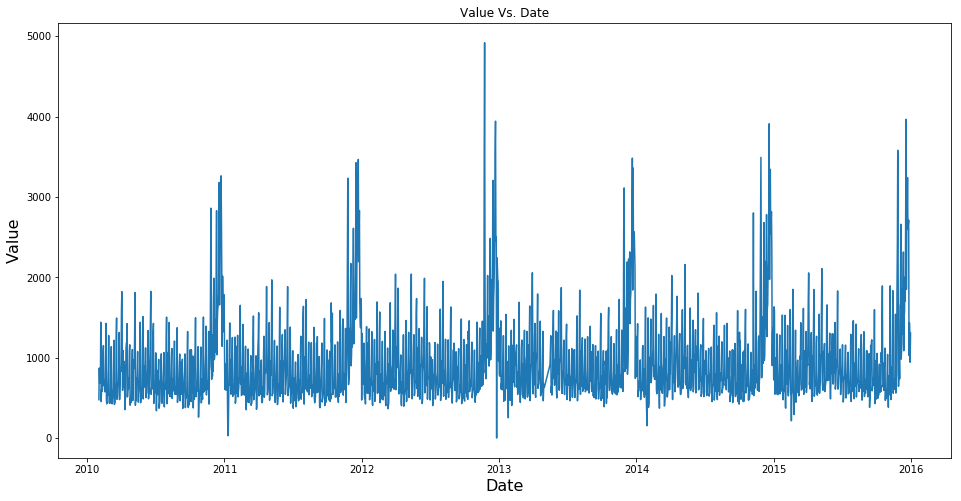

In [6]:
# Plot
plt.figure(figsize=(16,8))
plt.plot(data['value'])
plt.xlabel('Date',fontsize=16)
plt.ylabel('Value',fontsize=16)
plt.title('Value Vs. Date')

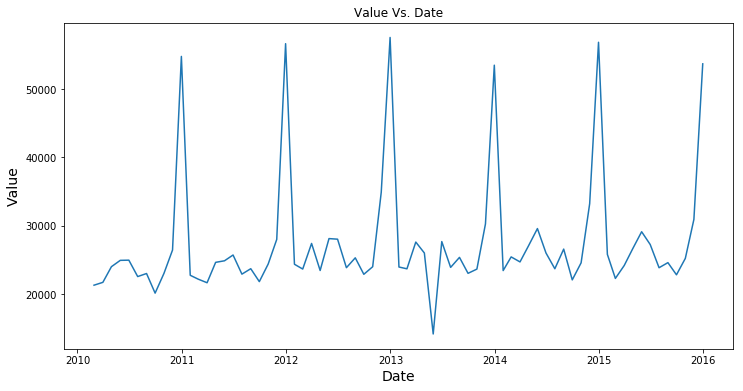

In [7]:
# Plot: Resampling data at monthly interval
plt.figure(figsize=(12,6))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Value',fontsize=14)
plt.title('Value Vs. Date')
plt.plot(data.resample('M').sum()['value'])

### Trendline
* We fit a linear equation on data and plot the line as trendline.
* Data has **slightly increasing trend**

In [8]:
data_monthly=data.resample('M').sum()

In [9]:
#Create equation

coefficients, residuals, _, _, _ = np.polyfit(range(len(data_monthly.index)),data_monthly['value'],1,full=True)

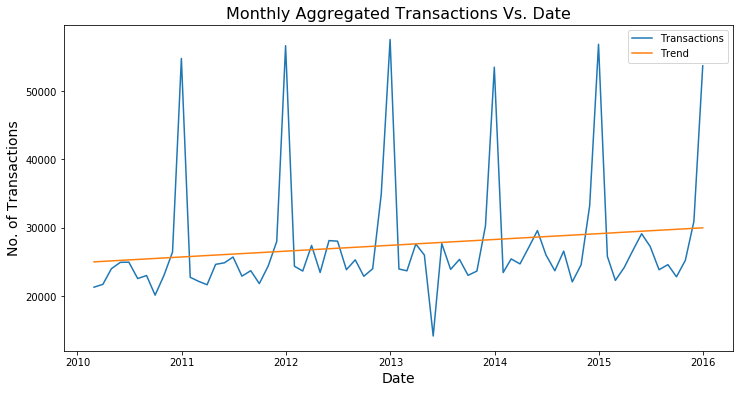

In [10]:
# Trendline
fig=plt.figure(figsize=(12,6))
plt.xlabel('Date',fontsize=14)
plt.ylabel('No. of Transactions',fontsize=14)
plt.title('Monthly Aggregated Transactions Vs. Date',size=16)

plt.plot(data_monthly['value'],label='Transactions')
plt.plot(data_monthly.index,[coefficients[0]*x + coefficients[1] for x in range(len(data_monthly['value']))],label='Trend')

plt.legend()

### Seasonality
1. Yearly seasonality
    - Sharp rise in transactions in November end and December.
    - Rise in transactions in Mar, Apr, May
2. Weekly seasonality
    - More transactons are done on Friday and Saturday.

#### Monthly Analysis

In [11]:
data_grouped_monthly=data.groupby('Month')['value'].sum()

Text(0.5,1,'Transactions Vs. Month')

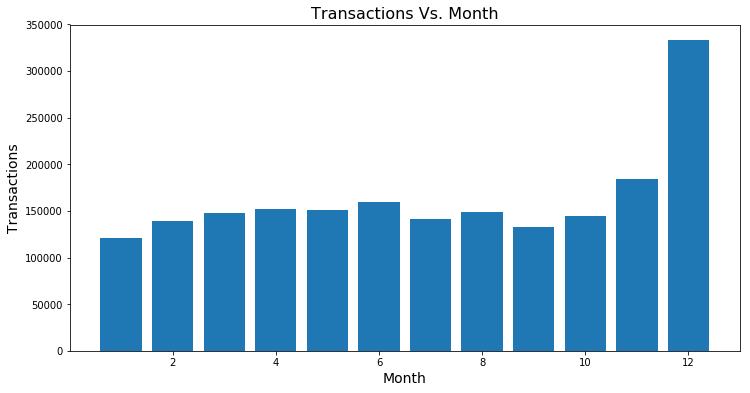

In [12]:
# Monthly plot
plt.figure(figsize=(12,6))
plt.bar(data_grouped_monthly.index,data_grouped_monthly)
plt.xlabel('Month',size=14)
plt.ylabel('Transactions',size=14)
plt.title('Transactions Vs. Month',size=16)

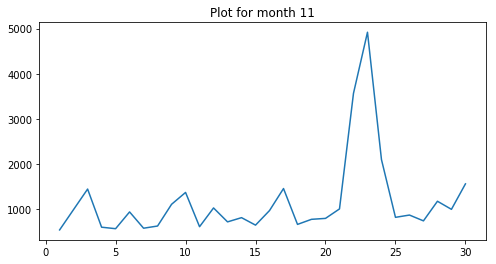

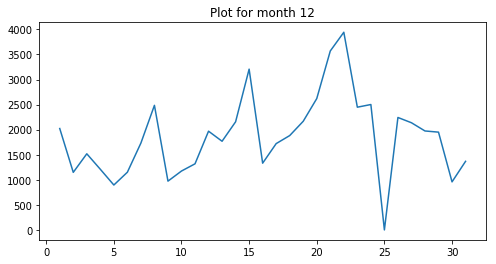

In [13]:
# Plot of Nov and Dec 2012
for month in [11,12]:
    tmp = data[data['Year']==2012]
    tmp=tmp[tmp['Month']==month]
    tmp=tmp.groupby('Day').sum()
    plt.figure(figsize=(8,4))
    plt.plot(tmp.index,tmp['value'])
    plt.title('Plot for month {}'.format(month))

#### Weekday-wise Analysis

In [14]:
data_weekday=data.groupby('Weekday')['value'].sum()

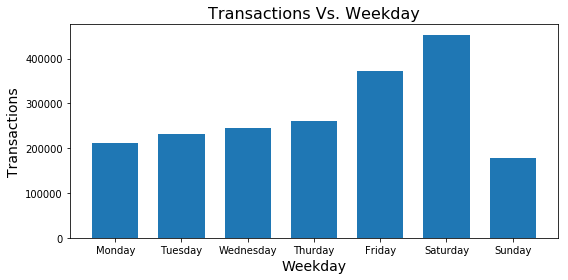

In [15]:
# Weekly plot
plt.figure(figsize=(8,4))
plt.bar(data_weekday.index,data_weekday,width=0.7)
plt.xlabel('Weekday',size=14)
plt.ylabel('Transactions',size=14)
plt.xticks(data_weekday.index,['Monday','Tuesday','Wednesday','Thurday','Friday','Saturday','Sunday'])
plt.title('Transactions Vs. Weekday',size=16)
plt.tight_layout()


Text(0.5,1,'Plot of Transactions for Thanks-Giving Week')

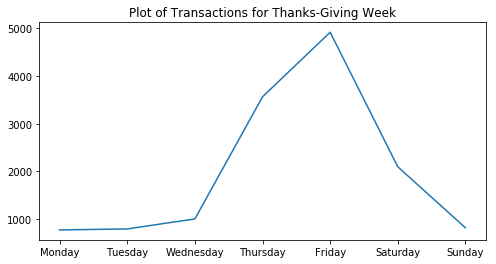

In [86]:
# Thanksgiving week
plt.figure(figsize=(8,4))
tmp = data['2012-11-19':'2012-11-25']
weekday_dict={1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',7:'Sunday'}
plt.plot(tmp['Weekday'].map(weekday_dict),tmp['value'])
plt.title('Plot of Transactions for Thanks-Giving Week',size=12)

### Effect of holidays and festivals
- Large amount of transactons in November end (Balck Friday), December end and Jaunary start.
- Some spikes can be seen around Valentine's Day, Mother's day, Easter.

Text(0.5,1,'HeatMap of Transactions for November')

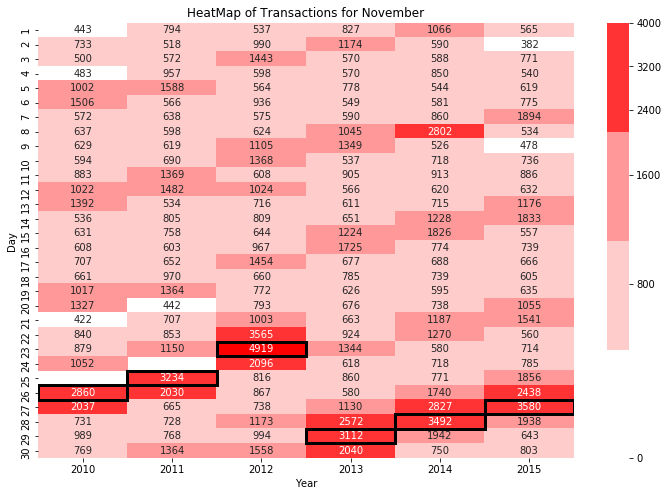

In [41]:
# November Plot (Box is Black Friday)
month=11

tmp=data[data['Month']==month]
tmp_pivot=tmp.pivot_table('value','Day','Year',aggfunc=lambda x:np.round(x))
plt.figure(figsize=(12,8))

colors = [(1,1,1), (1, 0, 0)]  # B -> W -> R
n_bin = 6  # Discretizes the interpolation into bins
n_bins_ranges = [0,500,1000,2000,4000]
cmap_name = 'my_list'
cm = matplotlib.colors.LinearSegmentedColormap.from_list(
            cmap_name, colors, N=n_bin)
norm = matplotlib.colors.BoundaryNorm(n_bins_ranges, len(n_bins_ranges))

hm=sns.heatmap(tmp_pivot,annot=True,fmt='g',cmap=cm,norm=norm)

blk_friday=[(26,2010),(25,2011),(23,2012),(29,2013),(28,2014),(27,2015)]
for cell in blk_friday:
    x_=list(tmp_pivot.columns).index(cell[1])
    y_=cell[0]-1
    hm.add_patch(Rectangle((x_,y_ ), 1, 1, fill=False,color='black',lw=3))
    
plt.title('HeatMap of Transactions for November')

Text(0.5,1,'HeatMap of Transactions for December')

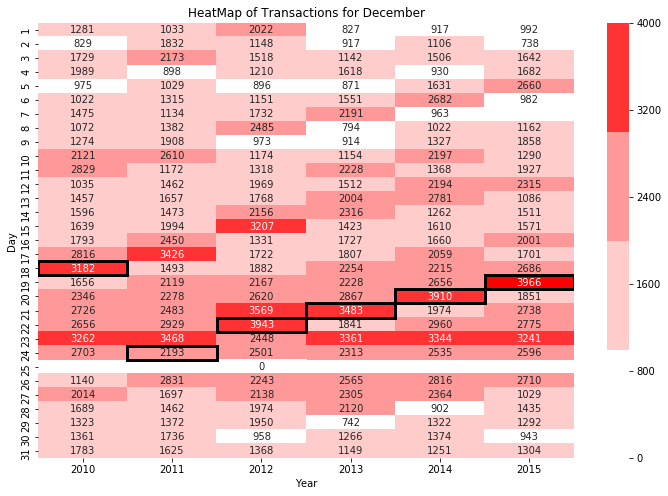

In [40]:
# December Plot (Box is Saturday before Christmas)

month=12
tmp=data[data['Month']==month]
tmp_pivot=tmp.pivot_table('value','Day','Year',aggfunc=lambda x:np.round(x))
plt.figure(figsize=(12,8))

colors = [(1,1,1), (1, 0, 0)]  # B -> W -> R
n_bin = 6  # Discretizes the interpolation into bins
n_bins_ranges = [0,1000,2000,3000,4000]
cmap_name = 'my_list'
cm = matplotlib.colors.LinearSegmentedColormap.from_list(
            cmap_name, colors, N=n_bin)
norm = matplotlib.colors.BoundaryNorm(n_bins_ranges, len(n_bins_ranges))

hm=sns.heatmap(tmp_pivot,annot=True,fmt='g',cmap=cm,norm=norm)

sat_b4_xmas=[(18,2010),(24,2011),(22,2012),(21,2013),(20,2014),(19,2015)]
for cell in sat_b4_xmas:
    x_=list(tmp_pivot.columns).index(cell[1])
    y_=cell[0]-1
    hm.add_patch(Rectangle((x_,y_ ), 1, 1, fill=False,color='black',lw=3))
    
plt.title('HeatMap of Transactions for December')

# Modeling Time-series

### Models:
1. Moving Average
2. Exponential smoothing
    - Simple exp smoothing
    - Double exp smoothing    
    - Triple exp smoothing
3. ARIMA
4. SARIMA 
5. FbProphet
6. ML Models
7. RNN/LSTM

#### If time-series has:
1. No trend, no seasonality and is stationary:
    - Moving Average
    - Simple exp smoothing
2. Trend only:
    - Double emp smoothing : need stationary TS
    - ARIMA
3. Trend and seasonality:
    - Triple exp smoothing : need stationaty TS
    - SARIMA
4. Trend, seasonality and holiday effects:
    - FbProphet
5. Effect of external variables:
    - FbProphet
    - ML models
    - LSTM


In this notebook we will see SARIMA, FbProphet and XGBoost

### Splitting time-series from validation:

Usual train-test split and k-fold cross validation does not work in case of time-series. These process ignore the temporal relations in the variable.

In case of time-series train and test data must be in order. It cannot be selected randomly as in case of other ML problems.

Sklearn provides **TimeSeriesSplit** class for this purpose. You can specify the number of splits.

Suppose, **y = [0,1,2,3,4,5]**, then TimeSeriesSplit with **5 splits** will return:
    1. TRAIN: [0] TEST: [1]
    2. TRAIN: [0 1] TEST: [2]
    3. TRAIN: [0 1 2] TEST: [3]
    4. TRAIN: [0 1 2 3] TEST: [4]
    5. TRAIN: [0 1 2 3 4] TEST: [5]

In [16]:
# imports and functions
from generate_ts_features import *
import holidays
from datetime import date
from pytime import pytime
from datetime import timedelta
from datetime import datetime as dt

import fbprophet as fp
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.special import boxcox1p,inv_boxcox1p


# functions

from sklearn.metrics import mean_squared_error
def mean_abs_pecent_error(y_true,y_pred):
    # Select values for which y_true is not zero
    y_pred=y_pred[y_true>0]
    y_true=y_true[y_true>0]
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def get_prev_saturday_of_christmas(year):
    d=pytime.christmas(year)
    offset=6-d.isoweekday()
    if offset>=0:
        return (d+timedelta(offset-7))
    else:
        return (d+timedelta(6-d.isoweekday()))

def get_friendship_day(year):
    d=dt.strptime('{}-08-01'.format(year),'%Y-%m-%d')
    offset=7-d.isoweekday()
    return d+timedelta(offset)


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [17]:
# Preparing data

data=pd.read_csv('data/one_unit.csv',parse_dates=['timestamp'])
# Add new features
create_date_features(data,'timestamp')
data=last_n_weekday_values(data,4)
data=get_last_month_same_weekday_value(data)
data=get_last_year_same_month_same_weekday_value(data)

data.tail()

,timestamp,value,Year,Month,Day,Weekday,WeekOfMonth,PrevWeek1,PrevWeek2,PrevWeek3,PrevWeek4,PrevMonth,PrevYear
2271,2016-05-27,1550.0,2016,5,27,5,4,1040.0,1185.0,1531.0,989.0,1145.0,1726.0
2272,2016-05-28,1670.0,2016,5,28,6,4,1667.0,1370.0,2504.0,2037.0,1412.0,1841.0
2273,2016-05-29,708.0,2016,5,29,7,5,779.0,627.0,801.0,560.0,659.0,714.0
2274,2016-05-30,1058.0,2016,5,30,1,5,762.0,603.0,652.0,673.0,617.0,1167.0
2275,2016-05-31,899.0,2016,5,31,2,5,820.0,649.0,746.0,1015.0,781.0,746.0


In [18]:
# Train Test Split

data.set_index('timestamp',inplace=True)
# split_date=data.index[-1]-timedelta(days=366)
split_date = dt.strptime('2015-11-15','%Y-%m-%d')

train_data=data[:split_date]
test_data=data[split_date+timedelta(days=1):]

train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

# Imputing nulls with Month-WeekOfMonth-Weekday mean
mean_df = train_data.groupby(['Month','WeekOfMonth','Weekday'])['value'].mean().reset_index().rename(columns={'value':'value_mean'})
mean_df['value_mean']=np.around(mean_df['value_mean'])
train_data = train_data.merge(mean_df,on=['Month','WeekOfMonth','Weekday'],how='left')

for col in train_data.columns:
    train_data.loc[train_data[col].isnull(),col]=train_data.loc[train_data[col].isnull(),'value_mean']
train_data.drop('value_mean',axis=1,inplace=True)

train_data.rename(columns={'timestamp':'ds','value':'y'},inplace=True)
test_data.rename(columns={'timestamp':'ds','value':'y'},inplace=True)

X_train=train_data.drop(['ds','y'],axis=1)
y_train=train_data['y']
X_test=test_data.drop(['ds','y'],axis=1)
y_test=test_data['y']

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [19]:
n_days_to_predict = 42

## SARIMA

* Seasonal Auto-Regressive Integrated Moving Average Model
* Can model non stationary time-series having trend as well as seasonality
* SARIMAX : can submit exogenous variables

### Parameters:
Trend Params: p, d, q

Seasonal  Params: P, D, Q, S

- p/P : Auto-regression parameter
- q/Q : Moving average parameter
- d/D : Difference order (To make time-series stationary)
- S : Number of time steps for a single seasonal period

### Insights from auto-correlation and partial auto-correlation plots:
- From PACF, AR factor(p) : 7
- From ACF, MA factor (q) : 11
- ACF shows peaks at constant interval of 7 indicating weekly seasonality. S = 7

### Issues with SARIMA:
- Good for one step or short  term forecasts, but not for long term forecasts
- Works for uni-variate data with linear relationships
- Focus on temporal dependence only. It does not consider events like holidays, promotions.

In [20]:
# Preparing data
train_data_smax=train_data.drop(['Year', 'Month', 'Day', 'Weekday', 'WeekOfMonth'],axis=1)
test_data_smax=test_data.drop(['Year', 'Month', 'Day', 'Weekday', 'WeekOfMonth'],axis=1)

train_data_smax=train_data_smax.set_index('ds').resample('D').sum()
test_data_smax=test_data_smax.set_index('ds').resample('D').sum().iloc[:n_days_to_predict]

# transforming data
train_data_smax = pd.DataFrame(boxcox1p(train_data_smax,0.01))
test_data_smax = pd.DataFrame(boxcox1p(test_data_smax,0.01))

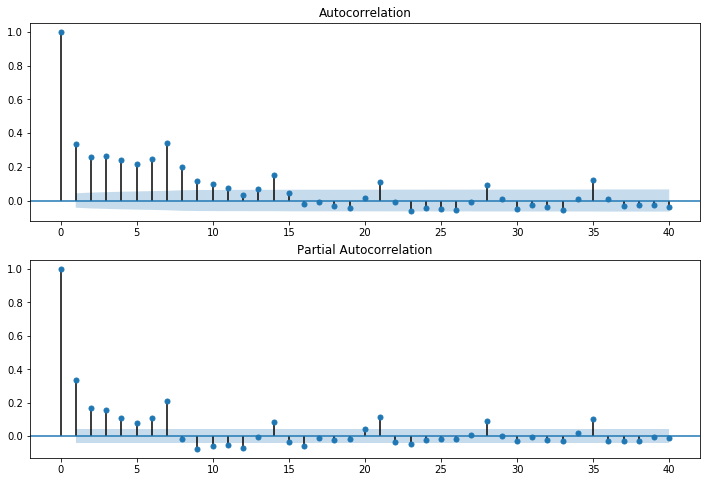

In [21]:
# Plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_data_smax['y'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_data_smax['y'], lags=40, ax=ax2)

In [22]:
# Model
model = SARIMAX(
    train_data_smax['y'],
    exog=train_data_smax.drop('y',axis=1),
    trend='t',
    order=(7,1,11),
    seasonal_order=(0,1,0,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 2114
Model:             SARIMAX(7, 1, 11)x(0, 1, 0, 7)   Log Likelihood               -1175.984
Date:                            Sat, 16 Nov 2019   AIC                           2403.969
Time:                                    13:24:20   BIC                           2550.786
Sample:                                02-01-2010   HQIC                          2457.752
                                     - 11-15-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.608e-08   7.55e-06      0.005      0.996   -1.48e-05    1.48e-05
PrevWeek1     -0.2204      0.015   

In [23]:
# Predictions

# Forecasting test data
steps = test_data_smax.shape[0]

forecast = results.get_forecast(steps=steps,
                                exog=test_data_smax.drop('y',axis=1)
                               )
yhat_test = inv_boxcox1p(forecast.predicted_mean.values,0.01)
yhat_test=pd.Series(yhat_test,index=test_data_smax.index)
y_test = inv_boxcox1p(test_data_smax['y'],0.01)

# excluding Christmans as it was not present in original data, but included by resample
yhat_test = yhat_test.loc[~yhat_test.index.isin(['2015-12-25'])] 
y_test = y_test.loc[~y_test.index.isin(['2015-12-25'])] 


# predictions on train_data
predictions = results.predict(start=train_data_smax.index.min(),
                                            end=train_data_smax.index.max())

yhat_train= inv_boxcox1p(predictions.values,0.01)
yhat_train=pd.Series(yhat_train,index=train_data_smax.index)
y_train=inv_boxcox1p(train_data_smax['y'],0.01)

yhat_sarimax=yhat_train.append(yhat_test)

C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [24]:
# Error of Sarimax Model
df=pd.DataFrame(index=['RMSE','MAPE(%)'],columns=['Training Set','Test Set'])
rmse=round(np.sqrt(mean_squared_error(y_train,yhat_train)),2)
mape=round(mean_abs_pecent_error(y_train,yhat_train),2)
df['Training Set']=[rmse,mape]

rmse=round(np.sqrt(mean_squared_error(y_test,yhat_test)),2)
mape=round(mean_abs_pecent_error(y_test,yhat_test),2)
df['Test Set']=[rmse,mape]

df

,Training Set,Test Set
RMSE,426.37,907.35
MAPE(%),24.64,34.25


Text(0.5,1,'Test and Predicted Data For SARIMAX')

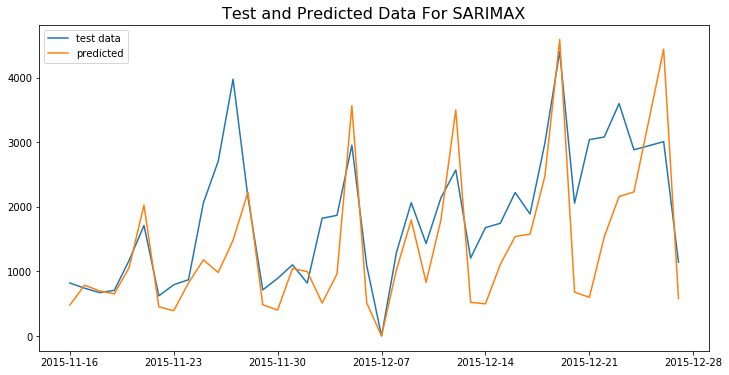

In [25]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test[:n_days_to_predict],label='test data')
plt.plot(yhat_test[:n_days_to_predict],label='predicted')
plt.legend()
plt.title("Test and Predicted Data For SARIMAX",size=16)

## FBProphet

### FbProphet's forecasting model:
The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

**y(t)= g(t) + s(t) + h(t) + εt**

- g(t): trend component
- s(t): periodic changes (e.g. weekly/yearly seasonality)
- h(t): effects of holidays (user provided) with irregular schedules
- εt: error term accounts for any unusual changes not accommodated by the model
- Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.


### Advantages of FbProphet over traditional models:
- works with trend as well as seasonality
- Can handle different seasonalities : daily, weekly, yearly
- Considers events like holidays, promotions
- Changepoints (points where trend changes significantly) can be identified automatically or can be supplied
- Handles outliers and null values better than SARIMA
- Can add exogenous variables as external regressors. It fits a linear regression on on these variables.

### Time-series components: 
FbProphet model provides following time-series components:
1. Trend
2. Seasonality : daily, weekly, yearly
3. Holiday component
4. Component for external regressor, if any.

These components can be used for further analysis.

In [26]:
# Prepare data for fbprophet
train_data_fp=train_data.drop(['Year', 'Month', 'Day', 'Weekday', 'WeekOfMonth'],axis=1)
test_data_fp=test_data.drop(['Year', 'Month', 'Day', 'Weekday', 'WeekOfMonth'],axis=1)

In [27]:
# Creating Holiday Dataframe

us_holidays=holidays.US(years=data['Year'].unique())
df_holidays = pd.DataFrame.from_dict(us_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

# Add new holidays
df_holidays['lower_window']=0
df_holidays['upper_window']=0

for year in range(2010,2016):
    ds=pytime.mother(year)
    holiday="Mother's Day"
    df_holidays=df_holidays.append({'ds':ds,'holiday':holiday,'lower_window':-1,'upper_window':7},ignore_index=True)
    
    ds=pytime.father(year)
    holiday="Father's Day"
    df_holidays=df_holidays.append({'ds':ds,'holiday':holiday,'lower_window':-1,'upper_window':7},ignore_index=True)
    
    ds=pytime.easter(year)
    holiday="Easter"
    df_holidays=df_holidays.append({'ds':ds,'holiday':holiday,'lower_window':-2,'upper_window':7},ignore_index=True)
    
    ds=get_prev_saturday_of_christmas(year)
    holiday="Prev Saturday of Christmas"
    df_holidays=df_holidays.append({'ds':ds,'holiday':holiday,'lower_window':0,'upper_window':0},ignore_index=True)
    
    ds=get_friendship_day(year)
    holiday="Friendship Day"
    df_holidays=df_holidays.append({'ds':ds,'holiday':holiday,'lower_window':-1,'upper_window':0},ignore_index=True)
    
#Change holiday windows
df_holidays.loc[df_holidays['holiday']=='Thanksgiving','lower_window']=-3
df_holidays.loc[df_holidays['holiday']=='Thanksgiving','upper_window']=2

df_holidays.loc[df_holidays['holiday']=='Christmas Day','upper_window']=2
df_holidays.loc[df_holidays['holiday']=='Christmas Day','lower_window']=-5

df_holidays.loc[df_holidays['holiday']=='Belk Days','upper_window']=7
    
df_holidays['ds']=df_holidays['ds'].apply(pd.Timestamp)
df_holidays.fillna(0,inplace=True)
df_holidays = df_holidays.sort_values('ds').reset_index(drop=True)
df_holidays.tail()

,ds,holiday,lower_window,upper_window
103,2016-10-10,Columbus Day,0,0
104,2016-11-11,Veterans Day,0,0
105,2016-11-24,Thanksgiving,-3,2
106,2016-12-25,Christmas Day,-5,2
107,2016-12-26,Christmas Day (Observed),0,0


In [28]:
# Fitting FbProphet Model
    
model = fp.Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=df_holidays,
            growth='linear',
            interval_width=0.9,
            seasonality_prior_scale=1,
            holidays_prior_scale=0.3,
        )

for col in train_data_fp.columns[2:]:
    model.add_regressor(col)
        
model.fit(train_data_fp)

# Forecasting on test data
forecast_test = model.predict(test_data_fp.drop('y',axis=1))
forecast_test_ci = forecast_test[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast_test.yhat.values
yhat_test=pd.Series(yhat_test,index=test_data_fp['ds'])

y_test = test_data_fp['y'].copy()
y_test.index=test_data_fp['ds'].copy()

# Forecasting on train data
forecast_train = model.predict(train_data_fp.drop('y',axis=1))
forecast_train_ci = forecast_train[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_train = forecast_train.yhat.values
yhat_train=pd.Series(yhat_train,index=train_data_fp['ds'])

y_train = train_data_fp['y'].copy()
y_train.index=train_data_fp['ds'].copy()

yhat_fp=yhat_train.append(yhat_test)

In [29]:
# Error of FbProphet Model

# # Error of FbProphet Model fot all test data
# df=pd.DataFrame(index=['RMSE','MAPE(%)'],columns=['Training Set','Test Set'])
# rmse=round(np.sqrt(mean_squared_error(y_train,yhat_train)),2)
# mape=round(mean_abs_pecent_error(y_train,yhat_train),2)
# df['Training Set']=[rmse,mape]

# rmse=round(np.sqrt(mean_squared_error(y_test,yhat_test)),2)
# mape=round(mean_abs_pecent_error(y_test,yhat_test),2)
# df['Test Set']=[rmse,mape]

# df

df=pd.DataFrame(index=['RMSE','MAPE(%)'],columns=['Training Set','Test Set'])
rmse=round(np.sqrt(mean_squared_error(y_train,yhat_train)),2)
mape=round(mean_abs_pecent_error(y_train,yhat_train),2)
df['Training Set']=[rmse,mape]

rmse=round(np.sqrt(mean_squared_error(y_test[:n_days_to_predict],yhat_test[:n_days_to_predict])),2)
mape=round(mean_abs_pecent_error(y_test[:n_days_to_predict],yhat_test[:n_days_to_predict]),2)
df['Test Set']=[rmse,mape]

df

,Training Set,Test Set
RMSE,180.18,318.33
MAPE(%),14.53,13.82


Text(0.5,1,'Test and Predicted Data For FbProphet')

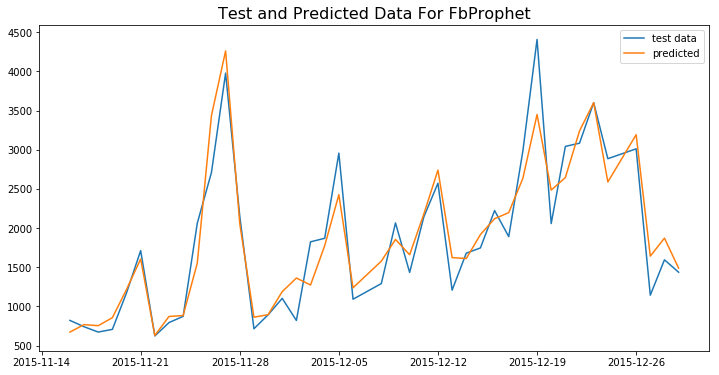

In [30]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test[:n_days_to_predict],label='test data')
plt.plot(yhat_test[:n_days_to_predict],label='predicted')
plt.legend()
plt.title("Test and Predicted Data For FbProphet",size=16)

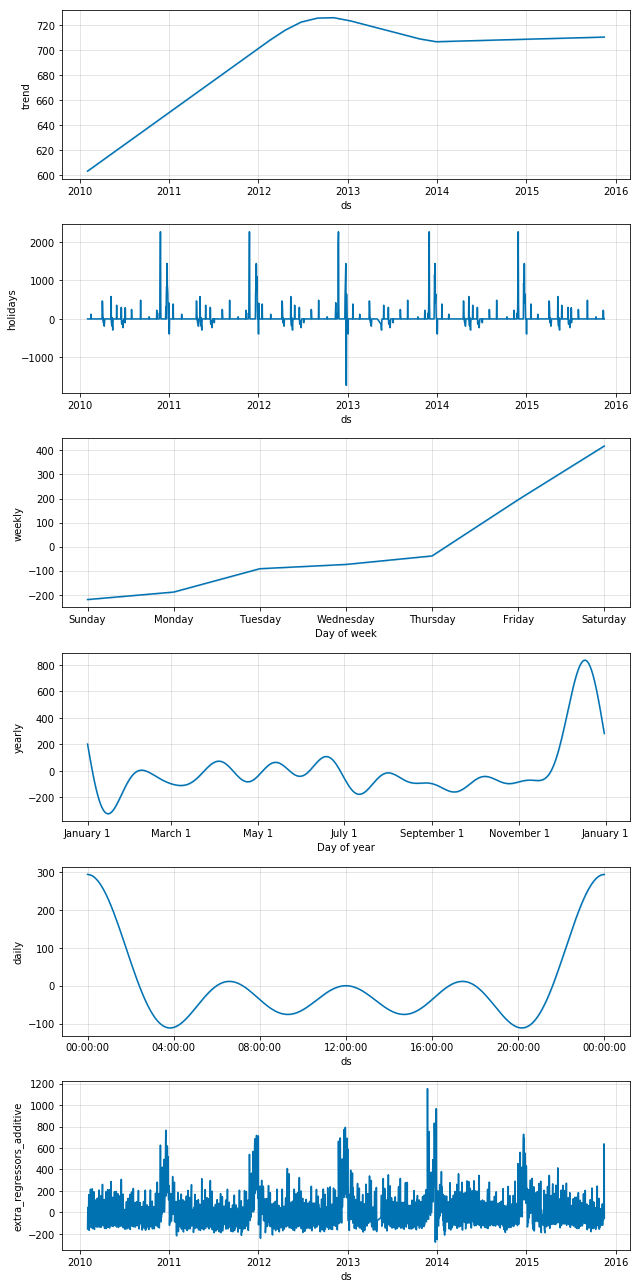

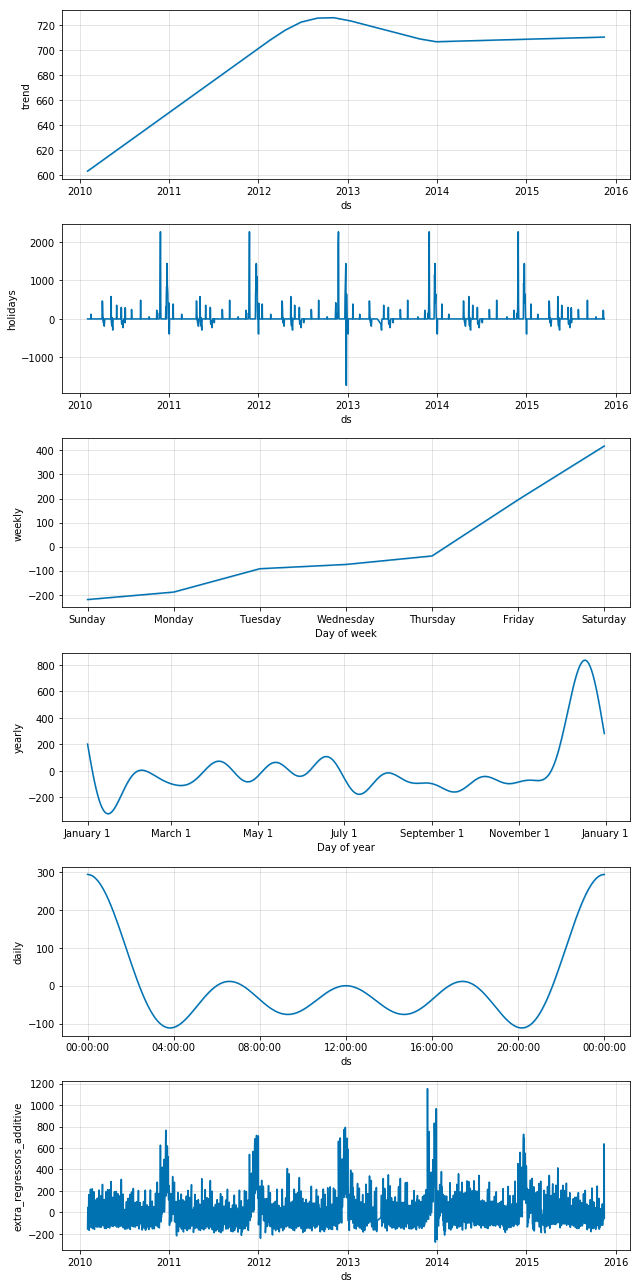

In [31]:
# TS Components
model.plot_components(forecast_train)

In [32]:
# Get seasonality components
train_comp_df=fp.plot.seasonality_plot_df(model,train_data_fp['ds'])
train_seas_comp=model.predict_seasonal_components(train_comp_df)

X_train['trend']=forecast_train.trend
X_train['yearly_seasonality']=train_seas_comp['yearly']
X_train['weekly_seasonality']=train_seas_comp['weekly']
X_train['holidays_comp']= train_seas_comp['holidays']

test_comp_df=fp.plot.seasonality_plot_df(model,test_data_fp['ds'])
test_seas_comp=model.predict_seasonal_components(test_comp_df)

X_test['trend']=forecast_test.trend
X_test['yearly_seasonality']=test_seas_comp['yearly']
X_test['weekly_seasonality']=test_seas_comp['weekly']
X_test['holidays_comp']= test_seas_comp['holidays']

## XGBoost

ML models are needed when:
- data is multi-variate. 
- if data has complex non-linear relations

But ML models do not model temporal dependencey. So, we feed time-series components modelled by fbprophet to ML model as additional features.

With this approach, a complex multi-variate time-series can be modelled. 


In [76]:
X_train.head()

,Year,Month,Day,Weekday,WeekOfMonth,PrevWeek1,PrevWeek2,PrevWeek3,PrevWeek4,PrevMonth,PrevYear,trend,yearly_seasonality,weekly_seasonality,holidays_comp
0,2010.0,2.0,1.0,1.0,1.0,517.0,517.0,517.0,517.0,517.0,517.0,603.463074,-45.352902,-188.937398,0.0
1,2010.0,2.0,2.0,2.0,1.0,1145.0,1145.0,1145.0,1145.0,1145.0,1145.0,603.603162,-32.045685,-91.854352,0.0
2,2010.0,2.0,3.0,3.0,1.0,729.0,729.0,729.0,729.0,729.0,729.0,603.743251,-20.817010,-74.061683,0.0
3,2010.0,2.0,4.0,4.0,1.0,802.0,802.0,802.0,802.0,802.0,802.0,603.883340,-11.686521,-38.730648,0.0
4,2010.0,2.0,5.0,5.0,1.0,987.0,987.0,987.0,987.0,987.0,987.0,604.023428,-4.626534,195.132581,0.0


In [33]:
# Training Model
# Fit

xgb=XGBRegressor(max_depth=6,reg_lambda=1,reg_alpha=0,colsample_bylevel=0.4,colsample_bytree=1,subsample=0.4,
                 learning_rate=0.1,n_estimators=100,min_child_weight=8,random_state=51)

xgb.fit(X_train,y_train)

# Predict
yhat_train=xgb.predict(X_train)
yhat_train=pd.Series(yhat_train,index=train_data_fp['ds'])

yhat_test=xgb.predict(X_test)
yhat_test=pd.Series(yhat_test,index=test_data_fp['ds'])


yhat_xgb=np.append(yhat_train,yhat_test)
y=data['value']

# df=pd.DataFrame(index=['RMSE','MAPE(%)'],columns=['Training Set','Test Set'])
# rmse=round(np.sqrt(mean_squared_error(y_train,yhat_train)),2)
# mape=round(mean_abs_pecent_error(y_train,yhat_train),2)
# df['Training Set']=[rmse,mape]

# rmse=round(np.sqrt(mean_squared_error(y_test,yhat_test)),2)
# mape=round(mean_abs_pecent_error(y_test,yhat_test),2)
# df['Test Set']=[rmse,mape]

# df

In [34]:
# Prediction for XGBoost

df=pd.DataFrame(index=['RMSE','MAPE(%)'],columns=['Training Set','Test Set'])
rmse=round(np.sqrt(mean_squared_error(y_train,yhat_train)),2)
mape=round(mean_abs_pecent_error(y_train,yhat_train),2)
df['Training Set']=[rmse,mape]

rmse=round(np.sqrt(mean_squared_error(y_test[:n_days_to_predict],yhat_test[:n_days_to_predict])),2)
mape=round(mean_abs_pecent_error(y_test[:n_days_to_predict],yhat_test[:n_days_to_predict]),2)
df['Test Set']=[rmse,mape]

df

,Training Set,Test Set
RMSE,127.62,307.04
MAPE(%),10.10,11.60


Text(0.5,1,'Test and Predicted Data For XGBoost')

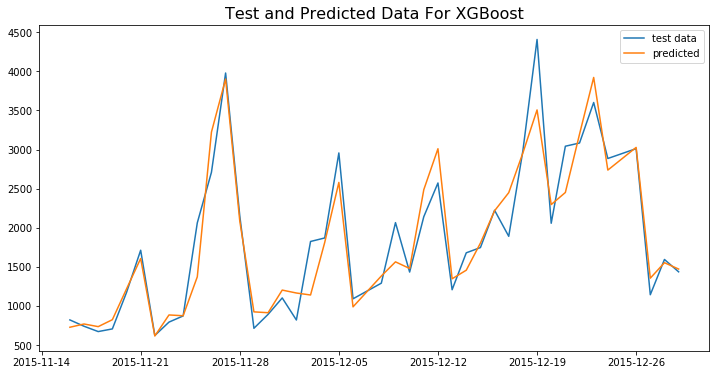

In [35]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test[:n_days_to_predict],label='test data')
plt.plot(yhat_test[:n_days_to_predict],label='predicted')
plt.legend()
plt.title("Test and Predicted Data For XGBoost",size=16)